# Refresh WFP data in Datamart

In [1]:
import sys
sys.path.append("../")

import io, glob
import pandas as pd
from utils import frame, ops
from requests import get,post,put,delete
from IPython.display import display, HTML

## All parameters are passed from commandline

In [2]:
# Parameters to be injected
template_path = 'WFP_template.tsv'
datasets_path = './datasets'
datamart_api_url = 'http://localhost:12543'
dataset_to_erase = None

### Remove datasets when needed

In [5]:
if not dataset_to_erase is None:
    ops.erase_dataset(datamart_api_url, dataset_to_erase)

### Load template into memory

In [6]:
df_template = frame.get_template(template_path)
df_template

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,dataset,WFP,WFP dataset,World food prices data compiled by the World F...,https://data.humdata.org/dataset/wfp-food-prices,,,,,,,,,,,,,
1,role,time,main subject,unit,qualifier,variable,unit,location,location,,qualifier,qualifier,qualifier,qualifier,qualifier,qualifier,qualifier,
2,type,%m/%d/%Y,string,string,string,number,string,country,admin1,,string,string,string,string,string,string,string,
3,description,,,,,,,,,,,,,,,,,
4,name,,,,,,,,,,,,,,,,,
5,unit,,,,,,,,,,,,,,,,,
6,header,date,cmname,unit,category,price,currency,country,admname,adm1id,mktname,mktid,cmid,ptid,umid,catid,sn,default
7,,,,,,,,,,,,,,,,,,
8,data,,,,,,,,,,,,,,,,,


### Build the pattern of files to be uploaded

In [7]:
patterns = ops.generate_targets(datasets_path)

### Build the sheet to be uploaded

In [9]:
dataset_id = df_template.iloc[0,1]

# This sheet holds all the datapoints to be uploaded
annotated_sheet = frame.get_template(template_path)
add_datatag = True

for p in patterns:
    for filename in glob.iglob(p):        
        annotated_sheet, add_datatag = frame.append_sheet(annotated_sheet, filename, add_datatag)

### Post the annotated sheet to datamart

In [11]:
frame.upload_annotated_sheet(annotated_sheet, dataset_id, datamart_api_url)

### Check the data has been uploaded

In [12]:
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
q_variable = 'price'
response = get(f"{datamart_api_url}/datasets/{dataset_id}/variables/{q_variable}")
df = pd.read_csv(io.StringIO(response.text))

In [14]:
# Try to catch the trends of price of Sorghum (Retail)
z = df[df['cmid']==65]
z.reset_index(drop=True, inplace=True)
# Generate y and x values
z = pd.concat([z['value'], z['time'].apply(lambda t: datetime.strptime(t,'%Y-%m-%dT%H:%M:%SZ').year)], axis=1)
z.columns = ['value', 'year']
z = z[['value','year']].groupby(['year']).mean()

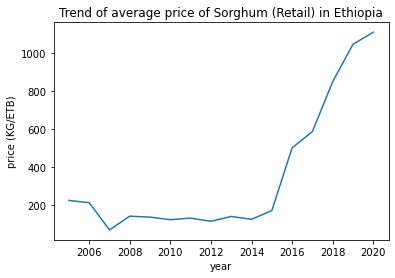

In [15]:
fig, ax = plt.subplots()
ax.plot(z.index,z['value'])

ax.set(xlabel='year', ylabel='price (KG/ETB)', title=f'Trend of average price of Sorghum (Retail) in Ethiopia')
plt.show()